<a href="https://colab.research.google.com/github/ayushpradhananga/Deep-Learning-Projects/blob/main/Weathher_forecast_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Weather forecasting with time-series data

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Predictive Modeling](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
## 1. Executive Summary

**Problem Definition:**
The objective of this task is to perform time-series analysis and forecasting for daily weather measures in Delhi from 2013 to 2017. Specifically, the goal is to develop a deep learning model to forecast the mean daily temperature ("meantemp") with a forecasting horizon of 2 weeks ahead. This task involves data exploration, data preprocessing, model development, and evaluation.

**Business Benefit:**
Accurate weather forecasting has significant implications for various industries, including agriculture, transportation, and disaster preparedness. A reliable forecasting model can aid in making informed decisions, optimizing resource allocation, and minimizing risks associated with weather-related events. Therefore, an effective weather forecasting model can lead to improved efficiency and cost savings for businesses and organizations operating in Delhi and the surrounding regions.

**Proposed Approaches and Major Findings:**

**Data Exploration:** The dataset containing daily weather measures from 2013 to 2017 was explored to understand its characteristics, including trends and seasonality.

**Data Preprocessing:** The data was preprocessed to , normalize features, and create suitable input sequences for time-series forecasting. Additionally, the data was split into training and testing sets.

**Model Development:** A deep learning model, Long Short-Term Memory (LSTM), was developed to forecast mean daily temperature for a 2-week forecasting horizon. Several models were experimented and the best model has been reported.

**Model Evaluation:** The model's performance was evaluated using metrics such as Mean Absolute Error (MAE). The evaluation results provide insights into the accuracy of the temperature forecasts. The lesser the error values the better.

**Major Findings:**

The RNN demonstrated the ability to forecast mean daily temperature up to 2 weeks ahead.
Evaluation metric MAE was used to assess the model's accuracy. Model with n_step = 65 and units =100 performed the best with consistent low MAE for 2 weeks ahead.

Further improvements in model performance can be achieved through hyperparameter tuning, model architecture adjustments, and the incorporation of additional weather-related features.
The model's forecasts have the potential to benefit various industries that rely on weather information for decision-making and resource management.

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

###Import Libraries and data


In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

###Import data

In [ ]:
# Read weather data from a CSV file into a Pandas DataFrame.
# The 'Date' column is set as the index and parsed as datetime.
weather_data = pd.read_csv("Part3_Weather.csv", index_col='Date', parse_dates=["Date"])

# Display the first few rows of the weather dataset.
weather_data.head()

<ipython-input-2-0d5bab1586c9>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  weather_data = pd.read_csv("Part3_Weather.csv", index_col='Date', parse_dates=["Date"])


,meantemp,humidity,wind_speed,meanpressure
Date,,,,
2013-01-01,10.000000,84.500000,0.000000,10.156667
2013-02-01,7.400000,92.000000,2.980000,10.178000
2013-03-01,7.166667,87.000000,4.633333,10.186667
2013-04-01,8.666667,71.333333,1.233333,10.171667
2013-05-01,6.000000,86.833333,3.700000,10.165000


###Data Exploration

In [ ]:
#Descriptive stats of the data
weather_data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1575.000000,1575.000000,1575.000000,1575.000000
mean,25.231582,60.420115,6.903642,10.105897
std,7.337316,16.956083,4.508803,1.752983
min,6.000000,13.428571,0.000000,-0.030417
25%,18.516667,49.750000,3.700000,10.018750
50%,27.166667,62.380952,6.370000,10.090000
75%,31.142857,72.125000,9.262500,10.151833
max,38.714286,98.000000,42.220000,76.793333


Missing Values

In [ ]:
weather_data.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

There are no missing values in the data.

###Plot the mean temperature

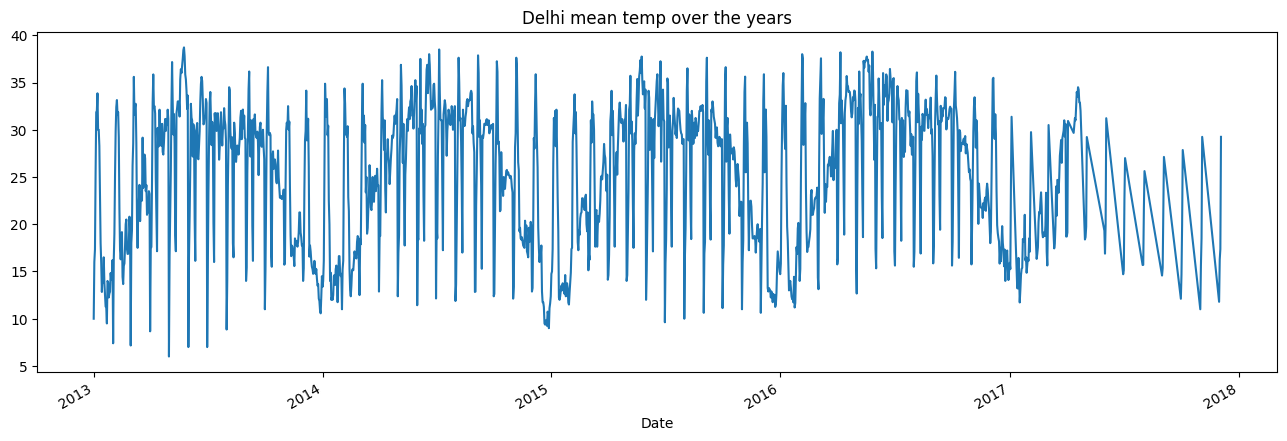

In [ ]:
# Plot Mean Temperature
weather_data['meantemp'].plot(figsize=(16, 5))
plt.title("Delhi mean temp over the years")
plt.show()

Looking at the temperature trend of Delhi, it looks that the mean temperature is between 6 degrees to 39 degrees. The seasonality effect can be seen from the chart showing patterns of low and high temperature during certain time of the year. However, in 2018 the temperature has been relatively low compared to previous years.

###Train Test Split

Data from 2013 to 2016 will be used as the training data and 2017 will be used as testing data.

This is a multivariate time series analysis and hence all the columns will be taken as predictors whereas the 'meantemp' column will be the label which will be predicted using RNN.

In [ ]:
tstart = 2013
tend = 2016

# Set a random seed for reproducibility
np.random.seed(455)

def train_test_split(dataset, tstart, tend):
    # Split the dataset into a training set (tstart to tend) and a test set (tend+1 onwards).
    train = dataset.loc[f"{tstart}":f"{tend}"]
    test = dataset.loc[f"{tend+1}":]
    return train, test

# Call the function to split the weather_data
training_set, test_set = train_test_split(weather_data, tstart, tend)

In [ ]:
# Get and display the shapes (dimensions) of the training and test sets.
training_set_shape = training_set.shape
test_set_shape = test_set.shape
print('training_set shape:', training_set_shape)
print('test_set shape:', test_set_shape)

training_set shape: (1461, 4)
test_set shape: (114, 4)


The training set consists of 1461 data points, each with 4 attributes, while the test set contains 114 data points with the same 4 attributes.

###Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the Min-Max scaler with a specified feature range (0, 1)
sc = MinMaxScaler(feature_range=(0, 1))

# Reshape the training set to a single column and apply Min-Max scaling
training_set = training_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

# Print the shape of the scaled training set
print('training_set_scaled shape after scaling:', training_set_scaled.shape)

training_set_scaled shape after scaling: (5844, 1)


In [ ]:
# Reshape the scaled training set back to its original shape (1461, 4).
training_set_scaled = training_set_scaled.reshape(training_set_shape[0], training_set_shape[1])

# Print the shape of the reshaped training set.
print('training_set_scaled shape:', training_set_scaled.shape)

training_set_scaled shape: (1461, 4)


The training set has be reshapped to restore its original shape.

In [ ]:
# Define a function to split a time sequence into input sequences (X) and target sequences (y).
def split_sequence(sequence, n_steps,forecasting_horizon, y_index):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon,y_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


# Define the number of time steps (n_steps), forecasting horizon, number of features, and the target column index (y_index).
n_steps = 65
forecasting_horizon = 14
features = 4
y_index = 0  # The index of the 'meantemp' column.

# Split the scaled training sequence into input samples (X_train) and target values (y_train).
X_train, y_train = split_sequence(training_set_scaled, n_steps, forecasting_horizon, y_index)


Since, the mean temperature needs to be predicted which means there is only one output but the number of features is four. Hence, the training set needs to be compatible for modelling where x train should have 4 features and y train should have 1 feature.

In [ ]:
# Reshaping X_train for model
y_train  = y_train.reshape(y_train .shape[0],y_train.shape[1],1)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (1383, 65, 4)
y_train shape: (1383, 14, 1)


###Plotting Training sample

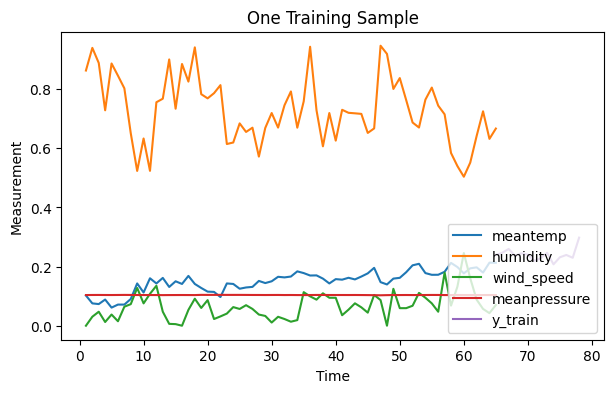

In [ ]:
# Specify a figure size
plt.figure(figsize=(7, 4))

# Plot individual features from a single training sample.
plt.plot(np.arange(1, n_steps+1, 1), X_train[0, :, 0])  # meantemp
plt.plot(np.arange(1, n_steps+1, 1), X_train[0, :, 1])  # humidity
plt.plot(np.arange(1, n_steps+1, 1), X_train[0, :, 2])  # wind_speed
plt.plot(np.arange(1, n_steps+1, 1), X_train[0, :, 3])  # meanpressure

# Plot the target values for forecasting.
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1), y_train[0])  # y_train

# Set plot title and labels for axes.
plt.title('One Training Sample')
plt.ylabel('Measurement')
plt.xlabel('Time')

# Add a legend to distinguish the plotted features.
plt.legend(['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'y_train'], loc='lower right')

<a id = "cell_model"></a>
## 3. Predictive Modeling

###RNN Training

In [ ]:
# Create the LSTM model
model_lstm = Sequential()

# Add an LSTM layer with 100 units
model_lstm.add(LSTM(units=100, activation="tanh", input_shape=(n_steps, features)))

# Add a Dense layer with 14 units
model_lstm.add(Dense(units=14))

# Compile the model with an RMSprop optimizer and mse loss function
model_lstm.compile(optimizer="RMSprop", loss="mse")

# Print the model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42000     
                                                                 
 dense (Dense)               (None, 14)                1414      
                                                                 
Total params: 43,414
Trainable params: 43,414
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
44/44 [==============================] - 12s 101ms/step - loss: 0.0104
Epoch 2/100
44/44 [==============================] - 5s 104ms/step - loss: 0.0028
Epoch 3/100
44/44 [==============================] - 3s 72ms/step - loss: 0.0020
Epoch 4/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0017
Epoch 5/100
44/44 [==============================] - 2s 45ms/step - loss: 0.0016
Epoch 6/100
44/44 [==============================] - 2s 46ms/step - loss: 0.0013
Epoch 7/100
44/44 [==============================] - 2s 46ms/step - loss: 0.0012
Epoch 8/100
44/44 [==============================] - 3s 71ms/step - loss: 0.0011
Epoch 9/100
44/44 [==============================] - 2s 46ms/step - loss: 0.0011
Epoch 10/100
44/44 [==============================] - 2s 46ms/step - loss: 0.0011
Epoch 11/100
44/44 [==============================] - 2s 47ms/step - loss: 9.9841e-04
Epoch 12/100
44/44 [==============================] - 2s 48ms/step - loss: 0.0011
Epoch 13/100
44/44

###Model Testing

In [ ]:
# Scale the test set and reshape it to a single column for scaling.
scaled_inputs = test_set.values.reshape(-1, 1)
scaled_inputs = sc.transform(scaled_inputs)

# Reshape the scaled inputs back to their original format.
scaled_inputs = scaled_inputs.reshape(test_set_shape[0], test_set_shape[1])

# Split the scaled test data into input samples (X_test) and target values (y_test).
X_test, y_test = split_sequence(scaled_inputs, n_steps, forecasting_horizon, y_index)

# Get the number of test samples.
num_test_samples = X_test.shape[0]

# Print the shapes of X_test and y_test.
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)


X_test shape: (36, 65, 4)
y_test shape: (36, 14)


The test data includes 36 sequences, each with 65 time steps and 4 features, while the target data consists of 36 sequences, each with 14 time steps for forecasting.

In [ ]:
# Make predictions using the LSTM model on the test data.
temp_predicted = model_lstm.predict(X_test)

# Inverse transform the predicted values to their original scale.
temp_predicted = sc.inverse_transform(temp_predicted)

# Print the shape of the predicted values.
print('temp_predicted shape: ', temp_predicted.shape)

# Inverse transform the test labels to their original scale.
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_test = sc.inverse_transform(y_test)

2/2 [==============================] - 1s 11ms/step
temp_predicted shape:  (36, 14)


###Model Evaluation

**Note on Variability in Model Performance:**

In the course of my experiments, I observed that my model encountered a certain degree of variability in its performance across multiple runs. This variability can be attributed to various factors, including the random initialization of weights and data shuffling among many more.

To ensure a level of reproducibility, I took specific measures, such as setting random seeds for weight initialization and data shuffling. Despite these efforts, the model's performance still exhibit slight differences from one run to another in metrics Mean Absolute Error (MAE).

To address this issue, I request considering not just the results of a single model run but rather examining the broader trends and performance averages across multiple runs. I have included a summary of experiment results in the final section which I averaged from 5 model runs per model.

In [ ]:
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error {:.2f}.".format(mae))

for i in range(forecasting_horizon):
  print("Forecasting Horizon: {} ".format(i))
  return_mae(y_test[:,i],temp_predicted[:,i])
  print("")

Forecasting Horizon: 0 
Mean Absolute Error 1.79.

Forecasting Horizon: 1 
Mean Absolute Error 2.23.

Forecasting Horizon: 2 
Mean Absolute Error 2.46.

Forecasting Horizon: 3 
Mean Absolute Error 2.70.

Forecasting Horizon: 4 
Mean Absolute Error 2.79.

Forecasting Horizon: 5 
Mean Absolute Error 3.05.

Forecasting Horizon: 6 
Mean Absolute Error 3.11.

Forecasting Horizon: 7 
Mean Absolute Error 2.99.

Forecasting Horizon: 8 
Mean Absolute Error 2.79.

Forecasting Horizon: 9 
Mean Absolute Error 3.05.

Forecasting Horizon: 10 
Mean Absolute Error 3.20.

Forecasting Horizon: 11 
Mean Absolute Error 3.12.

Forecasting Horizon: 12 
Mean Absolute Error 2.90.

Forecasting Horizon: 13 
Mean Absolute Error 2.79.



In [ ]:
X_test = X_test.reshape(-1, 65)
X_test = sc.inverse_transform(X_test)
X_test = X_test.reshape(num_test_samples, 65,4)

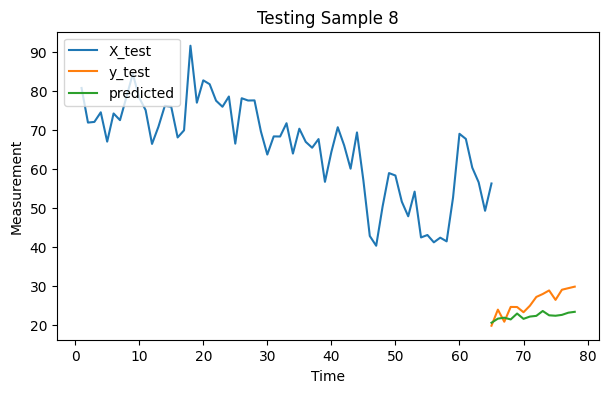

In [ ]:
#Here we visualize the real vs. predicted values of the last testing segment.
sample_index = 8

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_test[sample_index,:,1])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),temp_predicted[sample_index,:])
plt.title('Testing Sample ' + str(sample_index))
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_test', 'y_test', 'predicted'], loc='upper left')

###Plot true vs predicted values

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Mean Temperature Prediction")
    plt.xlabel("Days Ahead")
    plt.ylabel("Mean Temperature")
    plt.legend()
    plt.show()

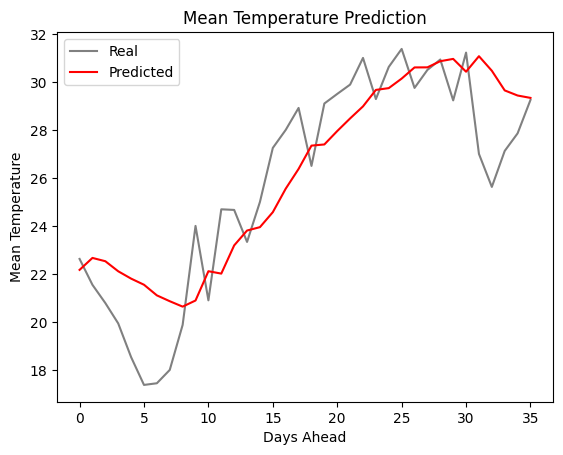

In [ ]:
#Here we visualize the real vs. predicted values for one day forecasting horizon.
plot_predictions(y_test[:,0],temp_predicted[:,0])

<a id = "cell_report"></a>
## 4. Experiments Report

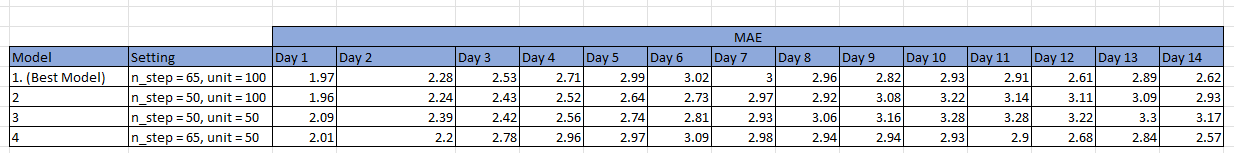

I used the Mean Absolute Error (MAE) metric as an indicator of predictive accuracy. Lower MAE values signify more accurate predictions.

It can be seen from the experiment summary that model 1 is the best performer as it consistently has low MAE. Model 2 is also very good. For forecasting horizon of 8, Model 2 seems to perform better than Model 1 but then over the 14 days, model 1 is better. It is natural to have lowe MAE as the forecasting horizon increases.

Delhi experiences extreme temperatures, during summer the temperature soars upto 40 degrees and during winters the temperature drops down very low. Governments and Schools can use this prediction from the model to schedule summer and winter vacations. Also, awareness advertising to cope with such extreme temperature can be run by various companies as well as non-profit organizations.